# Agra loan Pricer

In this document I will attempt to do an analytical pricing of loans against accounts in agra. We will take simplified cases and then attempt to extend  
The first will be lending against a simple Aave account

The net value of a loan on a DeFi Protocol can be expressed as:

$$
\sum_{i=1}^{n} a_i \cdot x_i \cdot e^{r_i \cdot t_i} - \sum_{j=1}^{m} a_j \cdot x_j \cdot e^{r_j \cdot t_j}
$$


Where all $x_i$ represent asset supplied, all $x_i$, represent assets lent.  
All $a_i$ represent the amount and $r_i$ and $t_i$ represent the borrow/lending rate and time they have been borrowed/lent for.  

For many loan protocols it is not the Net value but the quotient of their values that defines if the protocol is insolvent or not. So for something like Aave we know that it is solvent so long as 

$$
\frac{\sum_{i=1}^{n} a_i \cdot x_i \cdot e^{r_i \cdot t_i} \cdot l_i}{\sum_{j=1}^{m} a_j \cdot x_j \cdot e^{r_j \cdot t_j}} > 1
$$

Where $l_i$ is the liquidation threshold for collateral x (e.g 0.83 for eth on Aave mainnet)

But as soon as we hit the point where that is not true we have a liquidation 

If we were to provide a loan against an account which holds a position like this, in the case that we were to be liquidated we would receive 0 as there would be no incentive for the borrower to repay the loan

In the simplified case we will have a single asset borrowed against a single deposited. This is also the case where you loop though a lending protocol to get leverage

In this case the value of net value of the loan can be expressed as 
$$ a \cdot x  \cdot e^{r_1 \cdot t} - b \cdot y  \cdot e^{r_2 \cdot t} $$
And thus the liquidation threshold can be defined as
$$
\frac{a \cdot x  \cdot e^{r_1 \cdot t} \cdot l}{ b \cdot y  \cdot e^{r_2 \cdot t}} > 1 \rightarrow  l > \frac{ b \cdot y}{a \cdot x}e^{(r_2 - r_1) \cdot t}
$$

### Feel free to play with values

In [120]:
eth_supplied = 300
usc_borrowed = 300_000

rate_usdc = 0.05
rate_eth = 0.02

liquidation_threshold = 0.83

_time = 0.025  ## This is in years

In [121]:
from math import exp
import matplotlib.pyplot as plt

def is_liquidatable(supplied_price: float, supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> bool:
    return liquidation_threshold < (borrowed_price * borrowed_amount) / (supplied_price * supplied_amount) * exp((rate_borrowed - rate_supplied) * _time)

def account_value(supplied_price: float, supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> float:
    if is_liquidatable(supplied_price, supplied_amount, borrowed_price, borrowed_amount, rate_supplied, rate_borrowed, _time, liquidation_threshold):
        return 0
    return (supplied_price * supplied_amount) * exp(rate_supplied * _time) - (borrowed_price * borrowed_amount) * exp(rate_supplied * _time)

def liquidation_price(supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> float:
    return ((borrowed_amount * borrowed_price) / (supplied_amount * liquidation_threshold)) * exp((rate_borrowed - rate_supplied) * _time)

def buffer(supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> float:
    liq_price = liquidation_price(supplied_amount, borrowed_price, borrowed_amount, rate_supplied, rate_borrowed, _time, liquidation_threshold)
    return account_value(liq_price + 0.00001, supplied_amount, borrowed_price, borrowed_amount, rate_supplied, rate_borrowed, _time, liquidation_threshold)


value = [account_value(i, eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold) for i in range(1, 4000)]

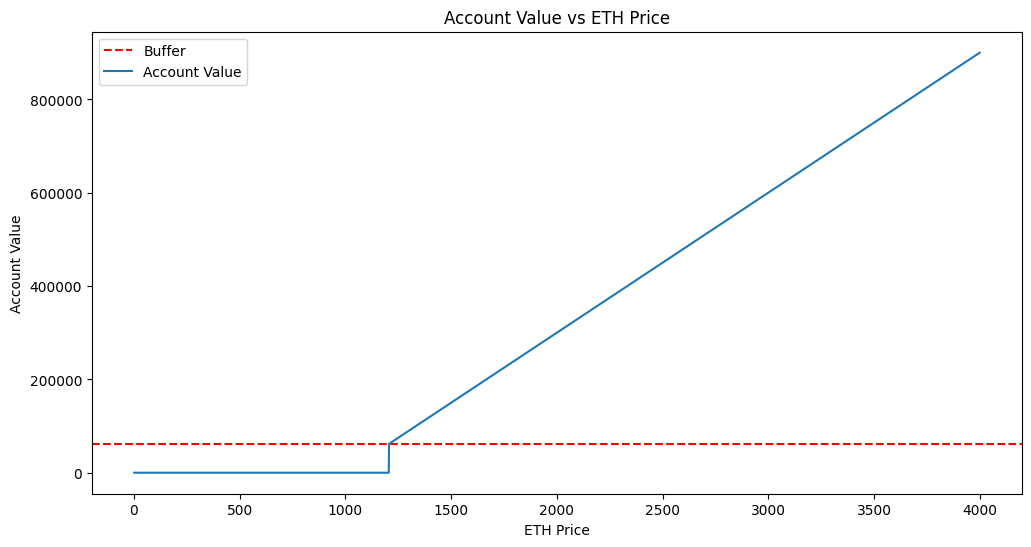

In [122]:
plt.figure(figsize=(12, 6))

buffer_account_value = buffer(eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold)

plt.axhline(y=buffer_account_value, color='r', linestyle='--', label='Buffer')

plt.plot(range(1, 4000), value, label='Account Value')
plt.ylabel('Account Value')
plt.xlabel('ETH Price')
plt.title('Account Value vs ETH Price')


# Add a legend to display the labels
plt.legend()

Now say you take out a loan against this the borrower will only pay you back if the value of the account is greater than the value of the loan

In [123]:
loan_amount = 150_000

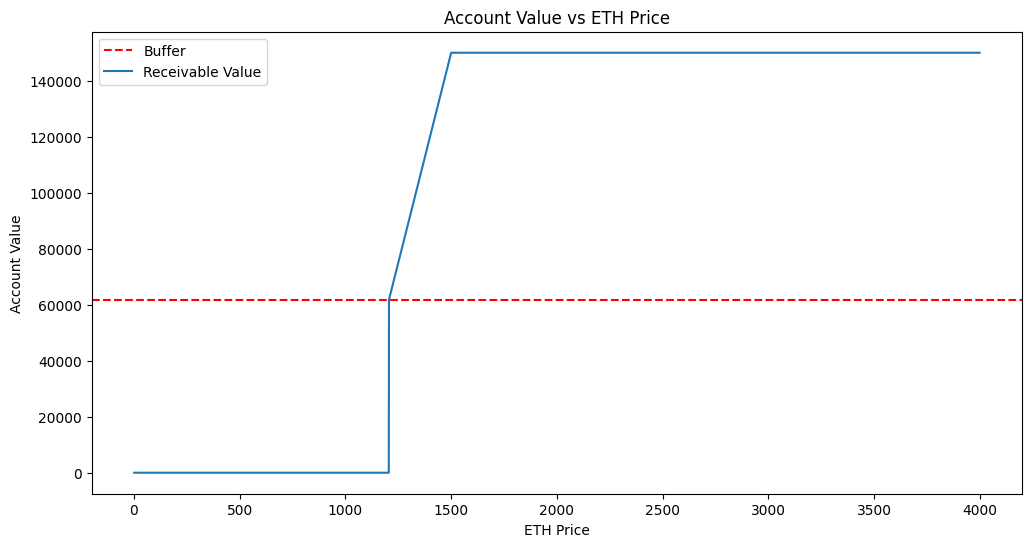

In [125]:
value = [min(account_value(i, eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold), loan_amount) for i in range(1, 4000)]

plt.figure(figsize=(12, 6))

plt.axhline(y=buffer(eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold) , color='r', linestyle='--', label='Buffer')

plt.plot(range(1, 4000), value, label='Receivable Value')
plt.ylabel('Account Value')
plt.xlabel('ETH Price')
plt.title('Account Value vs ETH Price')


# Add a legend to display the labels
plt.legend()

We can see that in the range between the liquidation point and the point at which the value of the account equals the amount loaned we move up steadily until we hit the cap.  
This is exactly long a call spread between these 2 values

In [95]:
def indifference_point(net_value: float, supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float)  -> float:
    return (net_value + borrowed_amount * borrowed_price * exp(rate_borrowed * _time)) / (supplied_amount * exp(rate_supplied * _time))

In [115]:
def put_spread(size: float, lower: float, upper: float, price: float) -> float:
    return size * (max(0, price - lower) - max(0, price - upper))

call_spreads = [put_spread( eth_supplied, liquidation_price( eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold),
                          indifference_point( loan_amount, eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time), i)
              for i in range(1, 4000)]

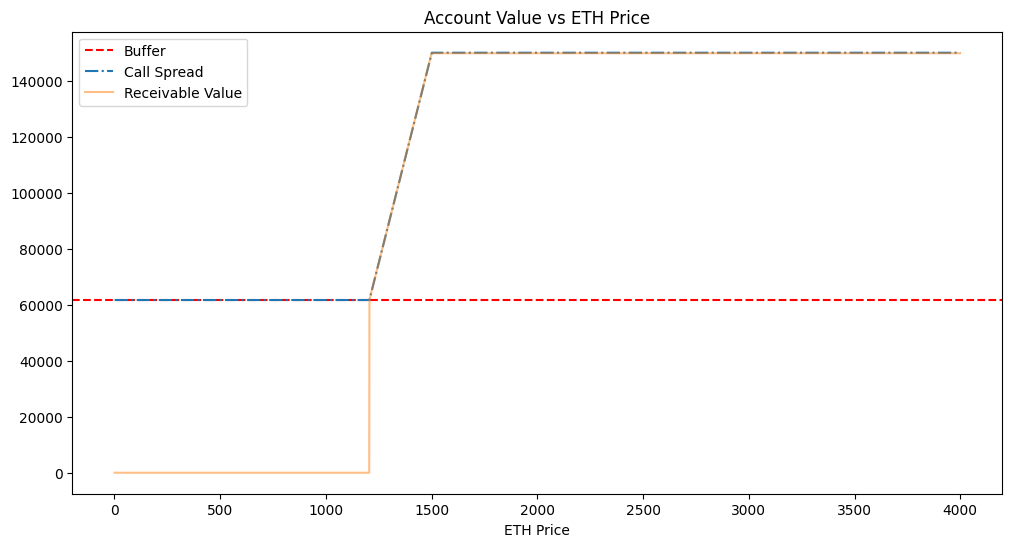

In [ ]:
plt.figure(figsize=(12, 6))

plt.axhline(y=buffer(eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold) , color='r', linestyle='--', label='Buffer')


plt.plot(range(1, 4000), [spr + buffer_account_value for spr in call_spreads], label='Call Spread', alpha=1, linestyle='dashdot')
plt.plot(range(1, 4000), value, label='Receivable Value', alpha=0.5)
plt.xlabel('ETH Price')
plt.title('Loan Repayed vs ETH Price')


# Add a legend to display the labels
plt.legend()